# Training a GPT Model on the Shahnameh Dataset

This notebook trains a GPT-style transformer model on the Shahnameh (شاهنامه), the epic Persian poem by Ferdowsi. We'll go through:

1. Loading and preprocessing the data
2. Building a tokenizer for Persian text
3. Creating a GPT model architecture
4. Training the model
5. Generating new Persian text in the style of Shahnameh

For full explanation of each section first refer to shakespeare-gpt.ipynb notebook.

Developed By Eiliya Mohebi For Educational Purposes.

Let's begin!

In [ ]:
# Install required libraries if needed
!pip install torch pandas matplotlib

## 1. Loading and Exploring the Dataset

We'll start by loading our Shahnameh dataset and exploring its structure.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import re
import os
from collections import Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
df = pd.read_csv('shahname.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head(100)

Using device: cuda
Dataset shape: (99222, 5)


,Chapter,Part,Bait,Mesra,Text
0,1,1,1,1,به نام خداوند جان و خرد
1,1,1,1,2,کز این برتر اندیشه بر نگذرد
2,1,1,2,1,خداوند نام و خداوند جای
3,1,1,2,2,خداوند روزی ده رهنمای
4,1,1,3,1,خداوند کیوان و گَردان سپهر
...,...,...,...,...,...
95,1,3,14,2,سر رستنی سوی بالا کشید
96,1,3,15,1,زمین را بلندی نبد جایگاه
97,1,3,15,2,یکی مرکزی تیره بود و سیاه
98,1,3,16,1,ستاره بر او بر شگفتی نمود


In [2]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Basic statistics
print(f"\nNumber of chapters: {df['Chapter'].nunique()}")
print(f"Number of parts: {df['Part'].nunique()}")
print(f"Number of verses (Bait): {df['Bait'].max()}")

# Check the distribution of text lengths
df['TextLength'] = df['Text'].str.len()
print(f"\nAverage text length: {df['TextLength'].mean():.2f} characters")
print(f"Min text length: {df['TextLength'].min()} characters")
print(f"Max text length: {df['TextLength'].max()} characters")

Missing values:
Chapter    0
Part       0
Bait       0
Mesra      0
Text       0
dtype: int64

Number of chapters: 61
Number of parts: 76
Number of verses (Bait): 890

Average text length: 24.85 characters
Min text length: 18 characters
Max text length: 34 characters


## 2. Data Preprocessing

Let's prepare our dataset by concatenating the text into a single corpus and handling any necessary cleaning.

In [3]:
# Function to preprocess Persian text
def preprocess_persian_text(text):
    # Handle half-space (ZWNJ) for Persian
    text = text.replace('\u200c', ' ')
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Apply preprocessing to each text entry
df['CleanText'] = df['Text'].apply(preprocess_persian_text)

# Combine all text into a single corpus
# We'll join verses with newlines to maintain poem structure
all_text = '\n'.join(df['CleanText'].tolist())

# Display statistics of the combined text
print(f"Total corpus length: {len(all_text)} characters")
print(f"First 300 characters:\n{all_text[:300]}...")

Total corpus length: 2565005 characters
First 300 characters:
به نام خداوند جان و خرد
کز این برتر اندیشه بر نگذرد
خداوند نام و خداوند جای
خداوند روزی ده رهنمای
خداوند کیوان و گَردان سپهر
فروزندهٔ ماه و ناهید و مهر
ز نام و نشان و گمان برتر است
نگارندهٔ بر شده پیکر است
به بینندگان آفریننده را
نبینی مرنجان دو بیننده را
نیابد بدو نیز اندیشه راه
که او برتر از نام و...


## 3. Character-Level Tokenization

For simplicity, we'll use character-level tokenization for Persian. This will handle all the Persian characters without needing a complex subword tokenizer.

In [5]:
# Get unique characters from the text
chars = sorted(list(set(all_text)))
vocab_size = len(chars)

# Create mappings from characters to indices and vice versa
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Display vocabulary information
print(f"Vocabulary size: {vocab_size} characters")
print(f"Sample characters: {''.join(chars[:20])}...")

# Encoding/decoding functions
def encode(text):
    return [char_to_idx[ch] for ch in text]

def decode(indices):
    return ''.join([idx_to_char[idx] for idx in indices])

# Test encoding/decoding
sample_text = all_text[:20]
encoded = encode(sample_text)
decoded = decode(encoded)

print(f"\nOriginal: {sample_text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")
print(f"Correctly decoded: {sample_text == decoded}")

Vocabulary size: 55 characters
Sample characters: 
 !():«»،؛؟ءآأؤئابتث...

Original: به نام خداوند جان و 
Encoded: [17, 40, 1, 39, 16, 38, 1, 22, 23, 16, 41, 39, 23, 1, 20, 16, 39, 1, 41, 1]
Decoded: به نام خداوند جان و 
Correctly decoded: True


## 4. Prepare Training Data

Now we'll convert our text corpus to tensors and prepare it for training.

In [6]:
# Convert the entire text to a tensor of indices
data = torch.tensor(encode(all_text), dtype=torch.long)

# Split into train and validation sets (90% train, 10% validation)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Move data to the device (GPU if available)
train_data = train_data.to(device)
val_data = val_data.to(device)

print(f"Training data length: {len(train_data)}")
print(f"Validation data length: {len(val_data)}")

Training data length: 2308504
Validation data length: 256501


## 5. GPT Model Architecture

Next, we'll define the architecture for our GPT model, which includes:
- Token embeddings
- Position embeddings
- Multi-head self-attention
- Feed-forward layers
- Layer normalization

In [7]:
class Head(nn.Module):
    """Single self-attention head"""
    
    def __init__(self, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # Register buffer for causal mask (triangle matrix)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)    # (B,T,head_size)
        q = self.query(x)  # (B,T,head_size)
        
        # Compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * (k.shape[-1] ** -0.5)  # (B,T,T)
        # Apply causal mask: mask out future positions (upper triangle)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B,T,T)
        wei = F.softmax(wei, dim=-1)  # (B,T,T)
        wei = self.dropout(wei)
        
        # Weighted aggregation of values
        v = self.value(x)  # (B,T,head_size)
        out = wei @ v  # (B,T,head_size)
        return out

In [8]:
class MultiHeadAttention(nn.Module):
    """Multiple self-attention heads in parallel"""
    
    def __init__(self, num_heads, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([
            Head(head_size, n_embd, block_size, dropout) for _ in range(num_heads)
        ])
        self.proj = nn.Linear(num_heads * head_size, n_embd)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Concatenate outputs from all heads
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        # Project back to residual pathway size
        out = self.proj(out)
        out = self.dropout(out)
        return out

In [9]:
class FeedForward(nn.Module):
    """Simple feed forward network"""
    
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)

In [10]:
class Block(nn.Module):
    """Transformer block: communication + computation"""
    
    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        self.ffwd = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        # Pre-norm residual connections
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [11]:
class PersianGPT(nn.Module):
    """GPT Language Model for Persian"""
    
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, dropout=0.1):
        super().__init__()
        self.block_size = block_size
        
        # Embeddings
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        
        # Transformer layers
        self.blocks = nn.Sequential(*[
            Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)
        ])
        
        # Final layer norm and projection to vocabulary
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        
        # Token embeddings
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        
        # Position embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)  # (T)
        pos_emb = self.position_embedding_table(pos)  # (T,C)
        
        # Combined embeddings
        x = tok_emb + pos_emb  # (B,T,C)
        
        # Apply transformer blocks
        x = self.blocks(x)  # (B,T,C)
        
        # Apply final layer norm
        x = self.ln_f(x)  # (B,T,C)
        
        # Project to vocabulary
        logits = self.lm_head(x)  # (B,T,vocab_size)
        
        # Compute loss if targets are provided
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """Generate text autoregressively"""
        for _ in range(max_new_tokens):
            # Crop context to block_size
            idx_cond = idx[:, -self.block_size:]
            
            # Get predictions
            logits, _ = self(idx_cond)
            
            # Focus only on the last time step
            logits = logits[:, -1, :] / temperature  # (B, vocab_size)
            
            # Optional: Apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, vocab_size)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            
            # Append to the sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
            
        return idx

## 6. Training Configuration

Define hyperparameters and set up the training environment.

In [12]:
# Hyperparameters
block_size = 256        # Context size (maximum sequence length)
batch_size = 64         # Batch size for training
n_embd = 384            # Embedding dimension
n_head = 6              # Number of attention heads
n_layer = 6             # Number of transformer blocks
dropout = 0.2           # Dropout rate
learning_rate = 3e-4    # Learning rate
max_iters = 5000        # Maximum training iterations
eval_interval = 500     # Evaluate every X iterations
eval_iters = 50         # Number of batches for evaluation

# Create the model and move it to the device
model = PersianGPT(
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    block_size=block_size,
    dropout=dropout
)
model = model.to(device)

# Print model size
print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters")

Model has 10,781,239 parameters


## 7. Data Loading and Loss Estimation Functions

In [13]:
# Function to get a batch of data
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,), device=device)
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

# Function to estimate loss on train and validation sets
@torch.no_grad()  # Disable gradient computation for efficiency
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters, device=device)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## 8. Model Training

Now let's train our Persian GPT model!

In [14]:
# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# For tracking training progress
train_losses = []
val_losses = []
iter_nums = []

# Training loop
print("Starting training...")
for iter in range(max_iters):
    # Evaluate loss every eval_interval
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_loss = losses['train'].item()
        val_loss = losses['val'].item()
        print(f"Step {iter}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")
        
        # Save for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        iter_nums.append(iter)
    
    # Sample a batch of data
    xb, yb = get_batch('train')
    
    # Evaluate the loss
    logits, loss = model(xb, yb)
    
    # Backpropagation
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print("Training complete!")

Starting training...
Step 0: train loss 4.1135, val loss 4.1153
Step 500: train loss 1.8575, val loss 1.8748
Step 1000: train loss 1.4829, val loss 1.5451
Step 1500: train loss 1.3476, val loss 1.4274
Step 2000: train loss 1.2563, val loss 1.3419
Step 2500: train loss 1.1816, val loss 1.2870
Step 3000: train loss 1.1352, val loss 1.2541
Step 3500: train loss 1.0948, val loss 1.2302
Step 4000: train loss 1.0654, val loss 1.2156
Step 4500: train loss 1.0376, val loss 1.2031
Step 4999: train loss 1.0116, val loss 1.2010
Training complete!


## 9. Plot Training Progress

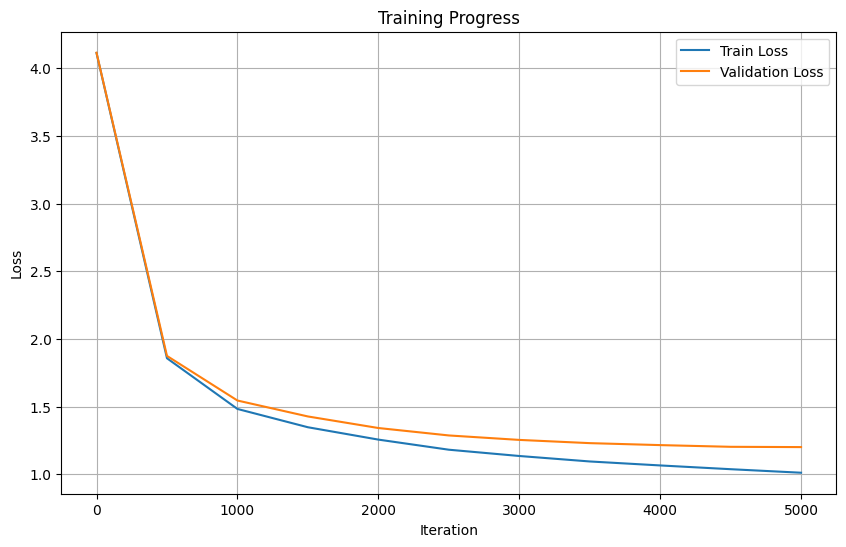

In [15]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(iter_nums, train_losses, label='Train Loss')
plt.plot(iter_nums, val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

## 10. Generate Persian Poetry in the Style of Shahnameh

In [16]:
# Function to generate text with different parameters
def generate_persian_poetry(model, seed_text="به نام خداوند", max_tokens=200, temperature=0.8, top_k=40):
    model.eval()
    
    # Encode the seed text
    if seed_text:
        context = torch.tensor([encode(seed_text)], dtype=torch.long, device=device)
    else:
        context = torch.zeros((1, 1), dtype=torch.long, device=device)
    
    # Generate tokens
    generated = model.generate(
        idx=context, 
        max_new_tokens=max_tokens,
        temperature=temperature,
        top_k=top_k
    )
    
    # Convert back to text
    generated_text = decode(generated[0].tolist())
    
    return generated_text

# Generate some examples with different parameters
print("=== Generated Persian Poetry (Temperature=0.8) ===")
print(generate_persian_poetry(model, seed_text="به نام خداوند", temperature=0.8))
print("\n=== Generated Persian Poetry (Temperature=1.0) ===")
print(generate_persian_poetry(model, seed_text="چو ایران", temperature=1.0))
print("\n=== Generated Persian Poetry (Temperature=0.5) ===")
print(generate_persian_poetry(model, seed_text="بدو گفت", temperature=0.5))

=== Generated Persian Poetry (Temperature=0.8) ===
به نام خداوند کیوان و مید
وگرنه نیابد برین گونه ای
همی از پی نام بهرام را
بدان نامداران به تخت و کلاه
بیارای ایران و بند و بسوخت
کسی را که تابنده کرد از نخست
به فرمان من بر نخواهم ز کس
سه دیگر بگفتم که شاها بسی
به

=== Generated Persian Poetry (Temperature=1.0) ===
چو ایران سپاه آمدند
بگسترد و دستان و سستان شدند
بپرسید و گفتش کمندش متاز
سپهبد بدین کار دیده براز
که از راستی دل شده هرچ گوی
ودیگر که پاکیزه برجای خویش
بگوید چو تو رستم آیدت پیش
زمانند رسم اندرین گفته ام
هران

=== Generated Persian Poetry (Temperature=0.5) ===
بدو گفت پیران که ای شهریار
به گیتی مرا گر بترس از مهار
چو بشنید گفتار او شهریار
بدان گه که آید به جای نبرد
پراندیشه شد پیش او شاد بود
بدو گفت موبد که ای شهریار
بدین مرزبان دار و بد روزگار
که ای شاه نوشین روا


## 11. Save the Trained Model

In [17]:
# Create a directory for models if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model weights
torch.save(model.state_dict(), 'models/persian_gpt_shahnameh.pth')

# Save vocabulary and model configuration
import json
model_config = {
    'vocab_size': vocab_size,
    'n_embd': n_embd,
    'n_head': n_head,
    'n_layer': n_layer,
    'block_size': block_size,
    'dropout': dropout,
    'char_to_idx': char_to_idx,
    'idx_to_char': {str(k): v for k, v in idx_to_char.items()}  # Convert keys to str for JSON
}

with open('models/persian_gpt_config.json', 'w', encoding='utf-8') as f:
    json.dump(model_config, f, ensure_ascii=False, indent=2)

print("Model and configuration saved successfully!")

Model and configuration saved successfully!


## 12. Conclusion

In this notebook, we've:
1. Loaded and preprocessed the Shahnameh dataset
2. Created a character-level tokenizer for Persian text
3. Built a GPT-style transformer model
4. Trained the model on Persian poetry
5. Generated new Persian poetry in the style of Shahnameh
6. Save the model

The model should be able to generate Persian text that mimics the style and structure of Ferdowsi's Shahnameh. You can continue training for more iterations to improve quality, or experiment with different model sizes and hyperparameters.